# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1. Loading Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
import seaborn as sns
import scipy.sparse as ss
import prettytable
from sklearn import tree
import collections
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_validate
import re # Go to https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
#positive_points = df[df['Score'] == 'positive'].sample(n=50000, random_state=0)#randomly sampling 20k positive points
#negative_points = df[df['Score'] == 'negative'].sample(n=50000, random_state=0)# randomly sampling 20k negative points
#total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
#sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
#                                        axis = 0,    #- ascending order so that we can do time based splitting later.
#                                     inplace = False, #inpace = false because we dont want to make modifications in-
                                      #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                      #- data in sorted_data
#                                    kind = 'quicksort',
#                                     na_position = 'last')
#sorted_data['Score'].value_counts()
#sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [4]:
sorted_data.shape

(40000, 13)

In [5]:
d_train = sorted_data.iloc[0:10000] #taking top 60k data points from sorted_data and storing it in d_train
d_cv = sorted_data.iloc[10000:15000]#taking next 20k data points from sorted_data and storing it in d_cv
d_test = sorted_data.iloc[15000:20000]#taking last 20k data points from sorted_data and storing it in d_test

In [6]:
#Storing 'CleanedText' and 'Score' columns in d_train into x_train and y_train respectively and doing the same for d_cv,
#-d_test
x_train = d_train['CleanedText']
x_cv = d_cv['CleanedText']
x_test = d_test['CleanedText']
y_train = d_train['Score']
y_cv = d_cv['Score']
y_test = d_test['Score']

In [7]:
#The below functio changes 'negative' to 0 and 'positive' to 1 in y_train, y_cv and y_test and thus binarizes the elements-
#- in y_train, y_cv and y_test such that now 1 will represent positive points and 0 will represent negative points
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_train:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_train = a
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [8]:
list_1 = []
for i in y_cv:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_cv = a
lb.fit(y_cv)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [9]:
list_1 = []
for i in y_test:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_test = a
lb.fit(y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [10]:
y_train = np.ravel(y_train)
y_cv = np.ravel(y_cv)
y_test = np.ravel(y_test)

In [11]:
y_train.shape

(10000,)

## 2. Bag of words

In [73]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer(min_df = 50) #defining our BOW model here. 
model = vectorizer.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'combin': 183, 'healthier': 422, 'review': 750, 'amaz': 30, 'cheaper': 153, 'low': 531, 'along': 24, 'ball': 67, 'cost': 209, 'deliv': 245, 'cherri': 157, 'deliveri': 246, 'continu': 201, 'new': 589, 'friend': 366, 'ingredi': 467, 'dont': 272, 'thick': 926, 'prompt': 700, 'post': 679, 'packag': 633, 'reduc': 731, 'dark': 234, 'content': 200, 'crunch': 225, 'spoon': 859, 'beef': 79, 'chees': 155, 'allerg': 18, 'soy': 853, 'cashew': 142, 'water': 1003, 'twice': 967, 'cinnamon': 171, 'guy': 411, 'immedi': 455, 'said': 764, 'lover': 530, 'final': 340, 'part': 640, 'bite': 91, 'could': 210, 'bulk': 120, 'ton': 947, 'bewar': 87, 'fruit': 369, 'youll': 1047, 'ship': 806, 'switch': 905, 'open': 617, 'local': 521, 'item': 476, 'see': 783, 'seller': 789, 'beauti': 77, 'count': 212, 'save': 773, 'point': 671, 'disappoint': 262, 'bunch': 121, 'your': 1048, 'veget': 986, 'hour': 445, 'actual': 5, 'air': 17, 'aroma': 48, 'shell': 805, 'aw': 58, 'advertis': 11, 'indic': 464, 'gross': 404, 'appreci':

In [74]:
train_bow = model.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [75]:
#here we are creating a dataframe out of train_bow,cv_bow and test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model.get_feature_names())

In [76]:
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

In [77]:
standardized_train.shape

(10000, 1052)

### 2.1 Random Forest on BOW

In [78]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1, 5, 10, 50, 100,200]#Max depth of tree
n_estimators = [5, 10, 30, 60,90] #no. of trees in the RF
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

In [79]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

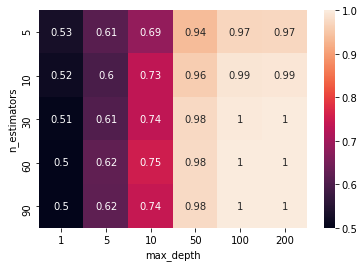

In [80]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

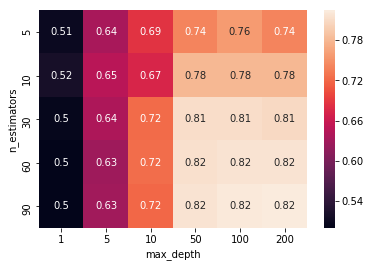

In [81]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 50 and n_estimators = 60 we are getting Area under ROC curve = 82%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [84]:
rfc = RandomForestClassifier(max_depth =  ij 50,n_estimators=60)
rfc.fit(standardized_train,y_train)
pred = rfc.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(50,60,roc_auc_score(y_test, pred)))


For max_depth = 50 and n_estimators = 60, the area under AUC curve is = 0.8121833835866051


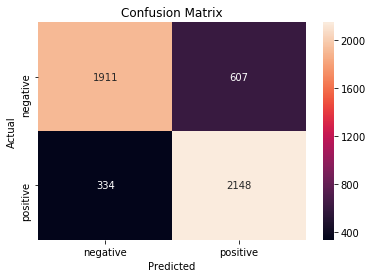

_____________________________________________________________________________________________________

For max_depth = 50 and n_estimators = 60, the TPR = 86.54311039484287, TNR = 75.89356632247815, FPR = 24.106433677521842, FNR = 13.456889605157132


In [85]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(50,60,TPR,TNR,FPR,FNR))

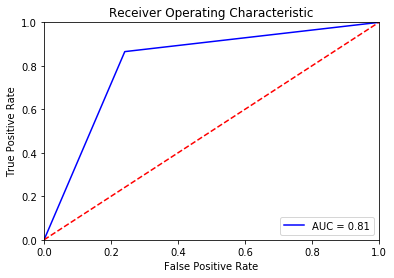

In [86]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [87]:
#Printing top 20 features
imp = rfc.feature_importances_
indices = np.argsort(imp)[::-1][:20]
names = np.array(model.get_feature_names())
print('Words','\t','\t','\t','Weights')
print('_'*50)
for i in indices:
    print(names[i],'\t','\t','\t',imp[i])

Words 	 	 	 Weights
__________________________________________________
great 	 	 	 0.034513773642334614
disappoint 	 	 	 0.02126665734889527
love 	 	 	 0.020721255903142482
best 	 	 	 0.019081929651342554
delici 	 	 	 0.015375765801361473
bad 	 	 	 0.009913549433390088
good 	 	 	 0.009660240400379615
would 	 	 	 0.009502492032879084
money 	 	 	 0.008615080000879736
excel 	 	 	 0.008607022819273837
favorit 	 	 	 0.008396957923270314
easi 	 	 	 0.008280337170600055
wast 	 	 	 0.007714887977980483
tast 	 	 	 0.007579418934854071
perfect 	 	 	 0.007559866969523355
product 	 	 	 0.007507046695111247
return 	 	 	 0.007423205154772875
didnt 	 	 	 0.007091031501806436
worst 	 	 	 0.00640686368862488
receiv 	 	 	 0.0063386401655002944


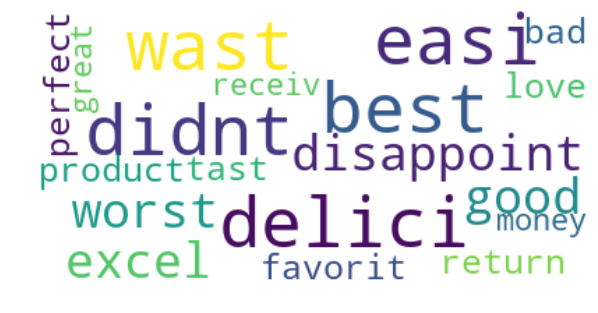

In [88]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(names[indices]))
plt.figure(figsize = [10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 2.2 GBDT on BOW

In [89]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1,2, 3, 4, 5, 6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

In [90]:
#Here we are trying to find area under AUC score  for cv dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 2, 3, 4, 5,6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

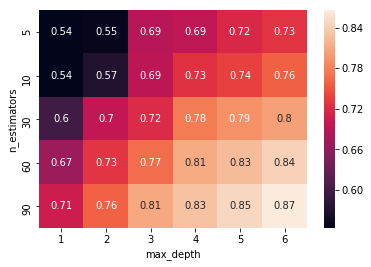

In [91]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

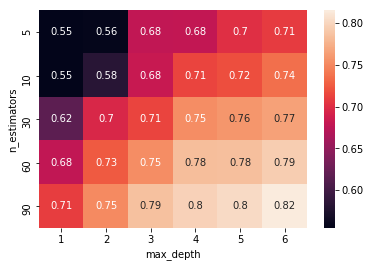

In [92]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 6 and n_estimators = 90 we are getting Area under ROC curve = 82%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [98]:
clf = XGBClassifier(max_depth = 6,n_estimators=90)
clf.fit(standardized_train,y_train)
pred = clf.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(6,90,roc_auc_score(y_test, pred)))


For max_depth = 6 and n_estimators = 90, the area under AUC curve is = 0.809437801255617


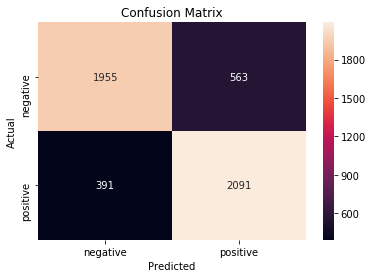

_____________________________________________________________________________________________________

For max_depth = 6 and n_estimators = 90, the TPR = 84.24657534246576, TNR = 77.64098490865766, FPR = 22.359015091342336, FNR = 15.753424657534246


In [99]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(6,90,TPR,TNR,FPR,FNR))

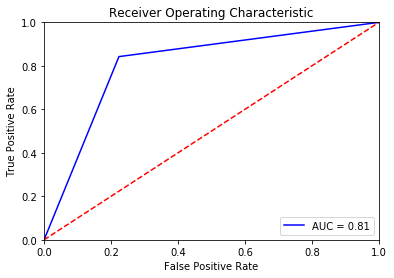

In [100]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [101]:
#Printing top 20 features
imp = rfc.feature_importances_
indices = np.argsort(imp)[::-1][:20]
names = np.array(model.get_feature_names())
print('Words','\t','\t','\t','Weights')
print('_'*50)
for i in indices:
    print(names[i],'\t','\t','\t',imp[i])

Words 	 	 	 Weights
__________________________________________________
great 	 	 	 0.034513773642334614
disappoint 	 	 	 0.02126665734889527
love 	 	 	 0.020721255903142482
best 	 	 	 0.019081929651342554
delici 	 	 	 0.015375765801361473
bad 	 	 	 0.009913549433390088
good 	 	 	 0.009660240400379615
would 	 	 	 0.009502492032879084
money 	 	 	 0.008615080000879736
excel 	 	 	 0.008607022819273837
favorit 	 	 	 0.008396957923270314
easi 	 	 	 0.008280337170600055
wast 	 	 	 0.007714887977980483
tast 	 	 	 0.007579418934854071
perfect 	 	 	 0.007559866969523355
product 	 	 	 0.007507046695111247
return 	 	 	 0.007423205154772875
didnt 	 	 	 0.007091031501806436
worst 	 	 	 0.00640686368862488
receiv 	 	 	 0.0063386401655002944


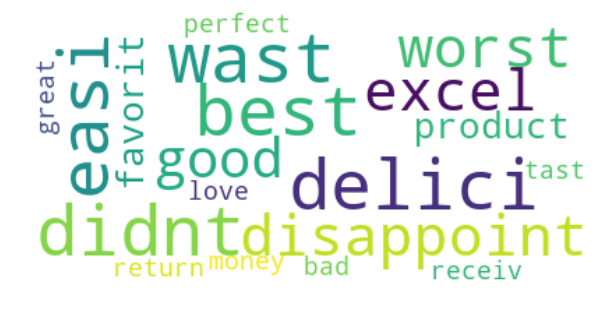

In [102]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(names[indices]))
plt.figure(figsize = [10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. TFIDF

In [12]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer(min_df = 50)#defining our tf-idf model and considering only those words which occur more than 10-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'break': 112, 'part': 640, 'rich': 752, 'search': 780, 'butter': 124, 'els': 291, 'though': 931, 'parti': 641, 'nice': 591, 'way': 1004, 'everyon': 307, 'interest': 472, 'replac': 742, 'finish': 343, 'stuck': 886, 'typic': 970, 'treat': 957, 'excit': 312, 'review': 750, 'safe': 763, 'tea': 915, 'com': 182, 'away': 59, 'impress': 458, 'crust': 227, 'anyway': 39, 'along': 24, 'air': 17, 'love': 529, 'diet': 255, 'heaven': 426, 'guy': 411, 'like': 514, 'lack': 496, 'boil': 100, 'plenti': 668, 'manufactur': 543, 'may': 547, 'cup': 228, 'valu': 981, 'fri': 365, 'kid': 489, 'chili': 163, 'crazi': 219, 'afternoon': 13, 'tree': 958, 'purpos': 708, 'increas': 461, 'load': 520, 'corn': 207, 'pound': 682, 'strong': 884, 'keurig': 487, 'countri': 213, 'imposs': 457, 'recent': 727, 'otherwis': 625, 'aw': 58, 'comparison': 188, 'individu': 465, 'holiday': 436, 'black': 93, 'health': 420, 'size': 825, 'produc': 698, 'truli': 963, 'veget': 986, 'ill': 453, 'okay': 611, 'tast': 912, 'noth': 597, 'beat

In [13]:
train_tfidf = model.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model.transform(x_cv)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_cv into matrices
test_tfidf = model.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [14]:
#here we are first creating a dataframes out of train_tfidf, cv_tfidf and test_tfidf
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model.get_feature_names())

In [15]:
standardized_train = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test = StandardScaler().fit_transform(test_tfidf_df)

### 3.1 Random Forest on TFIDF

In [107]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

In [108]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

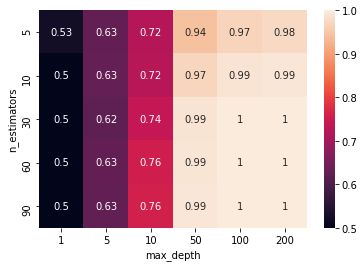

In [109]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

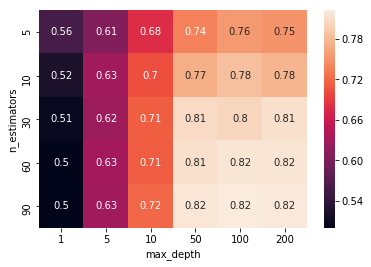

In [110]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 100 and n_estimators = 60 we are getting Area under ROC curve = 82%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [111]:
rfc = RandomForestClassifier(max_depth = 100,n_estimators=60)
rfc.fit(standardized_train,y_train)
pred = rfc.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(100,60,roc_auc_score(y_test, pred)))


For max_depth = 100 and n_estimators = 60, the area under AUC curve is = 0.8048938856990346


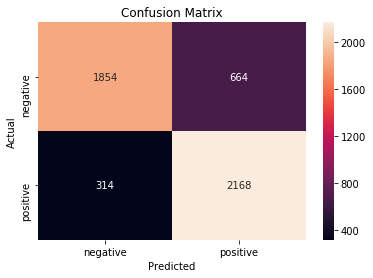

_____________________________________________________________________________________________________

For max_depth = 100 and n_estimators = 60, the TPR = 87.34891216760677, TNR = 73.62986497220015, FPR = 26.37013502779984, FNR = 12.651087832393232


In [112]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(100,60,TPR,TNR,FPR,FNR))

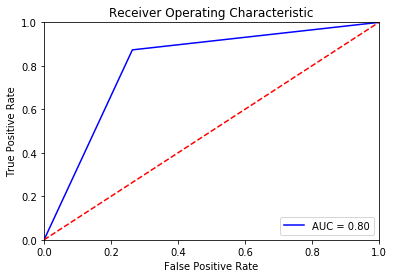

In [113]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [114]:
#Printing top 20 features
imp = rfc.feature_importances_
indices = np.argsort(imp)[::-1][:20]
names = np.array(model.get_feature_names())
print('Words','\t','\t','\t','Weights')
print('_'*50)
for i in indices:
    print(names[i],'\t','\t','\t',imp[i])

Words 	 	 	 Weights
__________________________________________________
great 	 	 	 0.03520591881316801
love 	 	 	 0.022805513395562263
disappoint 	 	 	 0.021595885883080746
best 	 	 	 0.019479776144341706
delici 	 	 	 0.014588121816376903
good 	 	 	 0.010851759142848066
tast 	 	 	 0.010340400096879704
would 	 	 	 0.009777656754569894
excel 	 	 	 0.008621567756820325
favorit 	 	 	 0.008515503071625102
bad 	 	 	 0.008417946178156051
find 	 	 	 0.007847736242083424
money 	 	 	 0.007159738102523762
didnt 	 	 	 0.007155819309805156
wast 	 	 	 0.006813571207740953
perfect 	 	 	 0.006463639125949651
wonder 	 	 	 0.006422292007209373
product 	 	 	 0.006259192126810467
easi 	 	 	 0.006227571200194785
receiv 	 	 	 0.006102207109365224


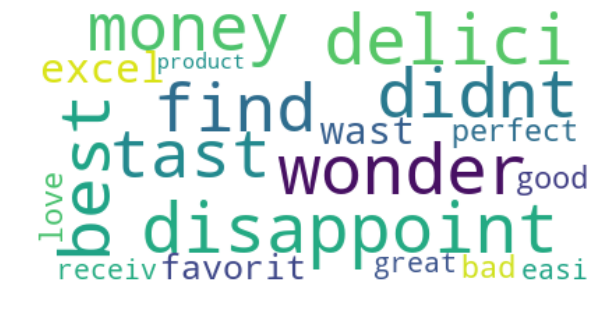

In [115]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(names[indices]))
plt.figure(figsize = [10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.2 GBDT on TFIDF

In [116]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1,2, 3, 4, 5, 6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

In [117]:
#Here we are trying to find area under AUC score  for cv dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 2, 3, 4, 5,6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

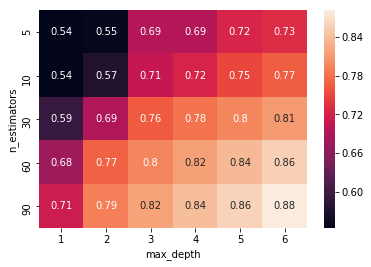

In [118]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

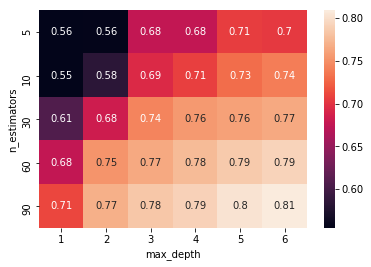

In [119]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 6 and n_estimators = 90 we are getting Area under ROC curve = 81%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [16]:
clf = XGBClassifier(max_depth = 6,n_estimators=90)
clf.fit(standardized_train,y_train)
pred = clf.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(6,90,roc_auc_score(y_test, pred)))


For max_depth = 6 and n_estimators = 90, the area under AUC curve is = 0.7969422734874576


/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


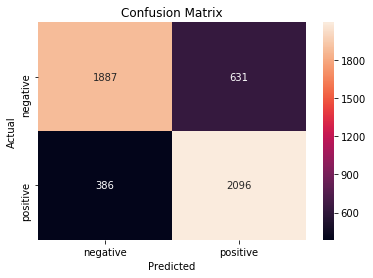

_____________________________________________________________________________________________________

For max_depth = 6 and n_estimators = 90, the TPR = 84.44802578565674, TNR = 74.94042891183479, FPR = 25.05957108816521, FNR = 15.551974214343273


In [17]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(6,90,TPR,TNR,FPR,FNR))

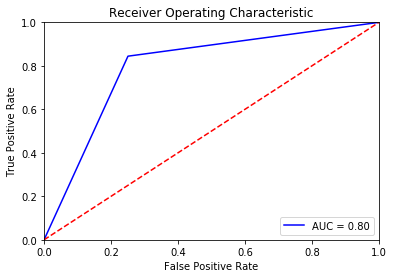

In [18]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
#Printing top 20 features
imp = clf.feature_importances_
indices = np.argsort(imp)[::-1][:20]
names = np.array(model.get_feature_names())
print('Words','\t','\t','\t','Weights')
print('_'*50)
for i in indices:
    print(names[i],'\t','\t','\t',imp[i])

Words 	 	 	 Weights
__________________________________________________
product 	 	 	 0.026121028
tast 	 	 	 0.021767523
great 	 	 	 0.020896822
love 	 	 	 0.01915542
would 	 	 	 0.017849369
best 	 	 	 0.017414019
good 	 	 	 0.016978668
like 	 	 	 0.013931215
disappoint 	 	 	 0.013495864
tri 	 	 	 0.013060514
delici 	 	 	 0.012625163
find 	 	 	 0.012625163
use 	 	 	 0.012189813
look 	 	 	 0.0117544625
tea 	 	 	 0.010883762
one 	 	 	 0.010448411
excel 	 	 	 0.00914236
day 	 	 	 0.00914236
bad 	 	 	 0.00914236
bought 	 	 	 0.008707009


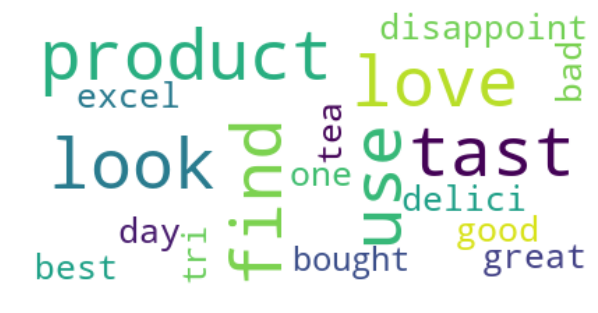

In [25]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(names[indices]))
plt.figure(figsize = [10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 4. Word2Vec

In [26]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [27]:
#splitting each of my reviews in x_cv into list of, list of stemmed words in each of our stemmed reviews in x_cv
list_of_sent_cv = []
for sent in x_cv.values:
    list_of_sent_cv.append(sent.split())

In [28]:
#splitting each of my reviews in x_test into list of, list of stemmed words in each of our stemmed reviews in x_test
list_of_sent_test = []
for sent in x_test.values:
    list_of_sent_test.append(sent.split())

In [29]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=4549, size=50, alpha=0.025)
['break', 'chronic', 'peet', 'pad', 'specialti', 'order', 'rebecca', 'burr', 'choic', 'wide', 'hydrolyz', 'dessert', 'funki', 'shade', 'inca', 'supris', 'sinus', 'halfway', 'rees', 'gonna', 'recycl', 'sweat', 'said', 'flower', 'tapioca', 'part', 'frog', 'sesam', 'evil', 'dress', 'rich', 'corner', 'connect', 'entre', 'tap', 'umf', 'latch', 'ting', 'tom', 'recipi', 'strainer', 'search', 'australia', 'shed', 'spinach', 'remedi', 'math', 'soil', 'juici', 'butter', 'rose', 'shepherd', 'bell', 'nearbi', 'becom', 'attempt', 'golean', 'reflux', 'scallop', 'vase', 'cousin', 'format', 'caramel', 'bizarr', 'mediterranean', 'heath', 'boat', 'african', 'command', 'though', 'swim', 'equip', 'parti', 'notic', 'wait', 'inevit', 'rat', 'inflat', 'theyll', 'msg', 'scotland', 'industri', 'measur', 'yerba', 'chock', 'publix', 'neutral', 'cilantro', 'franci', 'mega', 'scone', 'leather', 'genmai', 'fungus', 'shelti', 'glue', 'delet', 'fresh', 'younger', 'wind', 'pe

## 4.1 Average Word2Vec

In [30]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 10000/10000 [00:17<00:00, 560.69it/s]

10000
50


In [31]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 5000/5000 [00:10<00:00, 498.40it/s]

5000
50


In [32]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 5000/5000 [00:10<00:00, 485.34it/s]

5000
50


In [33]:
#here we are first creating a dataframe out of sent_vectors, sent_vectors_cv, sent_vectors_test
avg_w2v_tr = pd.DataFrame(sent_vectors)
avg_w2v_cv = pd.DataFrame(sent_vectors_cv)
avg_w2v_te = pd.DataFrame(sent_vectors_test)

In [34]:
standardized_train = StandardScaler().fit_transform(avg_w2v_tr)
standardized_cv = StandardScaler().fit_transform(avg_w2v_cv)
standardized_test = StandardScaler().fit_transform(avg_w2v_te)

### 4.1.1 Random Forest on Avg W2V

In [35]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

In [36]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

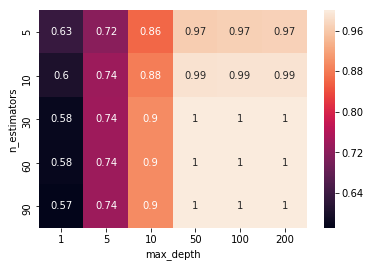

In [37]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

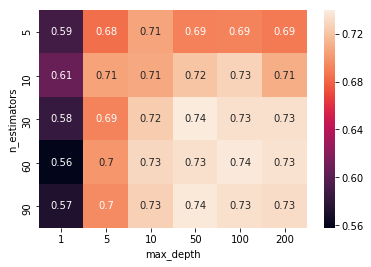

In [38]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 50 and n_estimators = 30 we are getting Area under ROC curve = 74%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [40]:
rfc = RandomForestClassifier(max_depth = 50,n_estimators=30)
rfc.fit(standardized_train,y_train)
pred = rfc.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(50,30,roc_auc_score(y_test, pred)))


For max_depth = 50 and n_estimators = 30, the area under AUC curve is = 0.7198737982577017


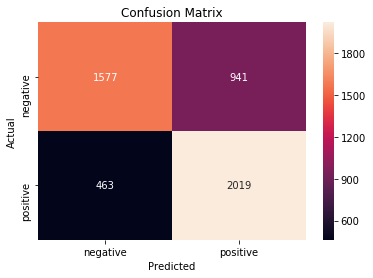

_____________________________________________________________________________________________________

For max_depth = 50 and n_estimators = 30, the TPR = 81.34568896051572, TNR = 62.62907069102462, FPR = 37.37092930897538, FNR = 18.654311039484288


In [42]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(50,30,TPR,TNR,FPR,FNR))

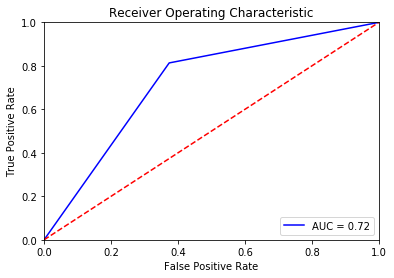

In [43]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.1.2 GBDT on Avg W2V

In [44]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1,2, 3, 4, 5, 6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [45]:
#Here we are trying to find area under AUC score  for cv dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 2, 3, 4, 5,6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

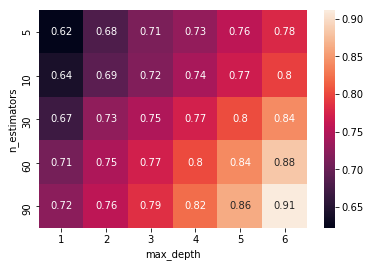

In [46]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

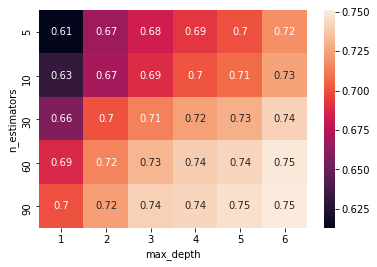

In [47]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 6 and n_estimators = 60 we are getting Area under ROC curve = 82%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [48]:
clf = XGBClassifier(max_depth = 6,n_estimators=60)
clf.fit(standardized_train,y_train)
pred = clf.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(6,60,roc_auc_score(y_test, pred)))


For max_depth = 6 and n_estimators = 60, the area under AUC curve is = 0.7399007564552146


/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


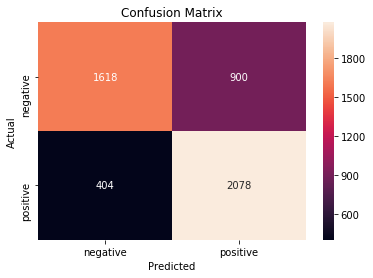

_____________________________________________________________________________________________________

For max_depth = 6 and n_estimators = 60, the TPR = 83.72280419016921, TNR = 64.2573471008737, FPR = 35.74265289912629, FNR = 16.277195809830783


In [49]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(6,60,TPR,TNR,FPR,FNR))

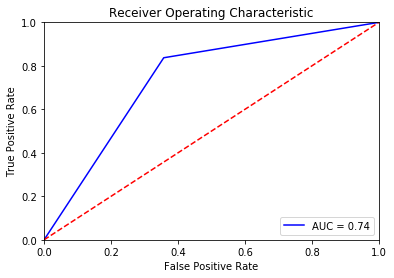

In [50]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.2 Weighted W2V

In [51]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model and considering only those words which occur more than 50-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'break': 1334, 'imagain': 5571, 'electrolyt': 3611, 'unreli': 11986, 'cassoulet': 1755, 'chuao': 2071, 'schnoodl': 9843, 'welllll': 12468, 'wide': 12558, 'constanc': 2435, 'saddend': 9680, 'ian': 5524, 'nosher': 7633, 'fleck': 4245, 'snacker': 10360, 'lash': 6316, 'envior': 3744, 'heartland': 5199, 'carcinogen': 1703, 'seedl': 9929, 'gonna': 4787, 'blunder': 1180, 'prem': 8722, 'literari': 6509, 'part': 8142, 'companionship': 2327, 'sesam': 10002, 'accpet': 52, 'streusel': 10828, 'elastis': 3603, 'bubblici': 1452, 'rich': 9491, 'tather': 11218, 'strawberriless': 10813, 'edward': 3577, 'entre': 3740, 'razzl': 9133, 'umf': 11827, 'ting': 11477, 'bragg': 1310, 'search': 9907, 'accustom': 58, 'coverag': 2587, 'assor': 631, 'burton': 1525, 'juici': 6042, 'butter': 1537, 'bisulfit': 1098, 'shepherd': 10078, 'groomer': 4949, 'bell': 973, 'nearbi': 7456, 'els': 3638, 'gunshot': 5020, 'vase': 12148, 'liquoric': 6498, 'dvita': 3507, 'mallo': 6732, 'rivera': 9535, 'prob': 8799, 'ineat': 5680, 'p

In [52]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [53]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|██████████| 10000/10000 [00:22<00:00, 449.12it/s]

10000
50


In [54]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

100%|██████████| 5000/5000 [00:12<00:00, 400.36it/s]

5000
50


In [55]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 5000/5000 [00:12<00:00, 392.43it/s]

5000
50


In [56]:
#here we are first creating a dataframes out of tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train)
tfidf_w2v_cv = pd.DataFrame(tfidf_sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(tfidf_sent_vectors_test)

In [57]:
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

### 4.2.1 Random Forest on Weighted W2V

In [58]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

In [59]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 5, 10, 50, 100,200]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        rfc = RandomForestClassifier(max_depth = i,n_estimators=j)
        rfc.fit(standardized_train,y_train)
        pred = rfc.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

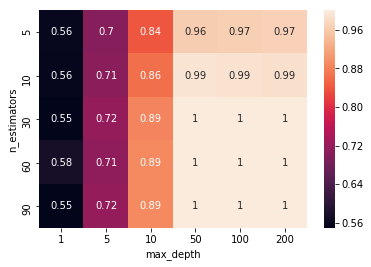

In [60]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

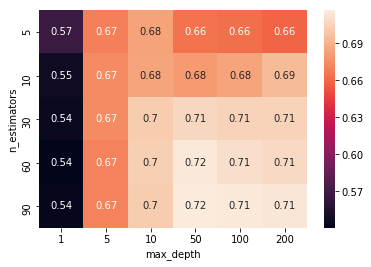

In [61]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 50 and n_estimators = 60 we are getting Area under ROC curve = 72%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [62]:
rfc = RandomForestClassifier(max_depth = 50,n_estimators=60)
rfc.fit(standardized_train,y_train)
pred = rfc.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(50,60,roc_auc_score(y_test, pred)))


For max_depth = 50 and n_estimators = 60, the area under AUC curve is = 0.6936279576733257


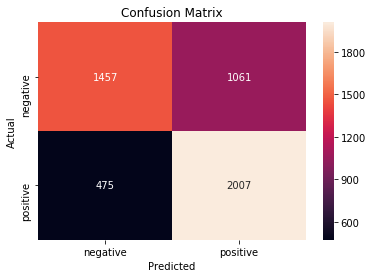

_____________________________________________________________________________________________________

For max_depth = 50 and n_estimators = 60, the TPR = 80.86220789685737, TNR = 57.863383637807786, FPR = 42.136616362192214, FNR = 19.137792103142626


In [64]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(50,60,TPR,TNR,FPR,FNR))

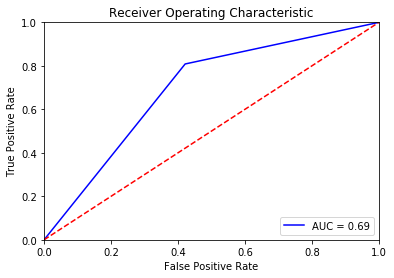

In [65]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.2.2 GBDT on Weighted W2V

In [66]:
#Here we are trying to find area under AUC score  for train dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
train_roc = []
n_estimator_train = []
max_depth_train = []
max_depth = [1,2, 3, 4, 5, 6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_train)
        train_roc.append(roc_auc_score(y_train, pred))
        n_estimator_train.append(j)
        max_depth_train.append(i)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [67]:
#Here we are trying to find area under AUC score  for cv dataset for various values of min_samples_split and max_depth-
#-Decision Tree Classifier
cv_roc = []
n_estimator_cv = []
max_depth_cv = []
max_depth = [1, 2, 3, 4, 5,6]
n_estimators = [5, 10, 30, 60,90]
for i in max_depth:
    for j in n_estimators:
        clf = XGBClassifier(max_depth=i,n_estimators=j)
        clf.fit(standardized_train,y_train)
        pred = clf.predict(standardized_cv)
        cv_roc.append(roc_auc_score(y_cv, pred))
        n_estimator_cv.append(j)
        max_depth_cv.append(i)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

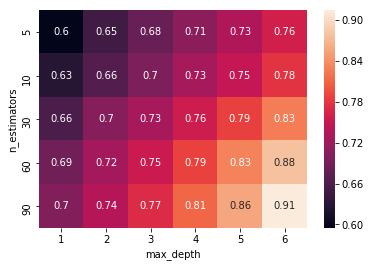

In [68]:
train_df = pd.DataFrame()
train_df['n_estimators'] = n_estimator_train
train_df['max_depth'] = max_depth_train
train_df['train_roc'] = train_roc
train_df = train_df.pivot("n_estimators", "max_depth", "train_roc")
ax = sns.heatmap(train_df, annot=True)

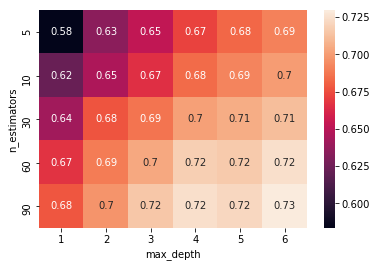

In [69]:
cv_df = pd.DataFrame()
cv_df['n_estimators'] = n_estimator_cv
cv_df['max_depth'] = max_depth_cv
cv_df['cv_roc'] = cv_roc
cv_df = cv_df.pivot("n_estimators", "max_depth", "cv_roc")
ax = sns.heatmap(cv_df, annot=True)

#### Observation:
<pre>As we can see from above that for max_depth = 6 and n_estimators = 90 we are getting Area under ROC curve = 73%. Therefore we will choose these values of our hyperparameters as our final values.</pre>

In [70]:
clf = XGBClassifier(max_depth = 6,n_estimators=90)
clf.fit(standardized_train,y_train)
pred = clf.predict(standardized_test)
print('\nFor max_depth = {0} and n_estimators = {1}, the area under AUC curve is = {2}'.format(6,90,roc_auc_score(y_test, pred)))


For max_depth = 6 and n_estimators = 90, the area under AUC curve is = 0.7193702521538716


/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


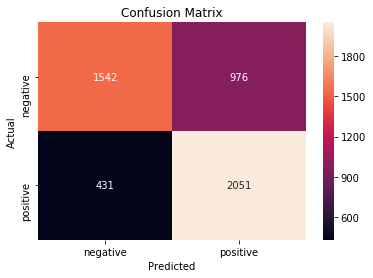

_____________________________________________________________________________________________________

For max_depth = 6 and n_estimators = 90, the TPR = 82.63497179693795, TNR = 61.23907863383637, FPR = 38.76092136616362, FNR = 17.365028203062046


In [71]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor max_depth = {0} and n_estimators = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(6,90,TPR,TNR,FPR,FNR))

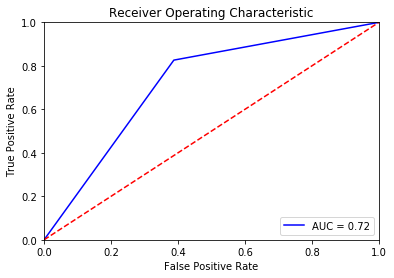

In [72]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()